# Mounting Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

# Importing Libraries

In [1]:
import os
from os import path
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import datasets, transforms, models
from PIL import Image

## Unzipping the zip file

In [ ]:
!unzip '/content/gdrive/MyDrive/4.2/CSE 4238/Dataset C.zip'

# Reading Data From the csv File

In [2]:
cols_csv = pd.read_csv('../input/cse-4238/Dataset C/training-c.csv')
# print(cols_csv.columns)

cols_csv.drop(cols_csv.columns[[1,2,4,5,6]], axis = 1, inplace = True)
print(cols_csv) 

cols_csv.to_csv('Datas.csv',index=False)

         filename  digit
0      c00000.png      6
1      c00001.png      1
2      c00002.png      3
3      c00003.png      2
4      c00004.png      7
...           ...    ...
24293  c24293.png      3
24294  c24294.png      2
24295  c24295.png      7
24296  c24296.png      2
24297  c24297.png      7

[24298 rows x 2 columns]


In [3]:
datas = pd.read_csv('Datas.csv')
datas.head(10) #First 5 Rows of the CSV File

,filename,digit
0,c00000.png,6
1,c00001.png,1
2,c00002.png,3
3,c00003.png,2
4,c00004.png,7
5,c00005.png,3
6,c00006.png,4
7,c00007.png,7
8,c00008.png,5
9,c00009.png,3


# Converting Images and Transforming them to Train and Test

In [4]:
class Dataset(Dataset):
    def __init__(self, df, root, transform=None):
        self.data = df
        self.root = root
        self.transform = transform
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        item = self.data.iloc[index]
        
        path = self.root + "/" + item[0]
        image = Image.open(path).convert('L')
        label = item[1]
        
        if self.transform is not None:
            image = self.transform(image)
            
        return image, label

In [21]:
mean = [0.5,]
std = [0.5,]

train_transform = transforms.Compose([
    transforms.Resize(28),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

test_transform = transforms.Compose([
        transforms.Resize(28),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
])

TRAIN_PATH = '../input/cse-4238/Dataset C/training-c'
train_data = Dataset(datas, TRAIN_PATH, train_transform)
test_data = Dataset(datas, TRAIN_PATH, test_transform)

print("Trainig Samples: ",len(train_data))
print("Test Samples: ",len(test_data))

Trainig Samples:  24298
Trainig Samples:  24298


# Hyperparameter Setting 6 Exp.2
*   No of hidden layers = 3
*   Hidden Nodes = 784-300-200-100-10
*   Iteration = 80000
*   Learning rate = 0.05
*   Batch Size = 64
*   Activation Function : ReLU,ReLU6
*   Optimizer : SGD
*   Accuracy : 85.16%

In [52]:
batch_size = 64
num_iters = 80000
input_dim = 28*28
output_dim = 10
learning_rate = 0.05
num_hidden = 300  #number of hidden nodes
# Device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# split data 20% for testing
test_size = 0.2

# obtain training indices that will be used for validation
num_train = len(train_data)

# mix data
# index of num of train
indices = list(range(num_train))
# random the index
np.random.shuffle(indices)
split = int(np.floor(test_size * num_train))
# divied into two part
train_idx, test_idx = indices[split:], indices[:split]

print(len(train_idx))

# define the sampler
train_sampler = SubsetRandomSampler(train_idx)
test_sampler = SubsetRandomSampler(test_idx)

# prepare loaders
train_loader = torch.utils.data.DataLoader(
    train_data, batch_size=batch_size,
    sampler=train_sampler)

test_loader = torch.utils.data.DataLoader(
    test_data, batch_size=batch_size,
    sampler=test_sampler)

print("Train dataloader:{}".format(len(train_loader)))
print("Test dataloader:{}".format(len(test_loader)))

19439
Train dataloader:304
Test dataloader:76


In [53]:
num_epochs = num_iters / (len(train_idx) / batch_size)
num_epochs = int(num_epochs)
print(num_epochs)

263


# Creating Neural Network Model

In [54]:

class DeepNeuralNetworkModel(nn.Module):
    def __init__(self, input_size, num_classes, num_hidden):
        super().__init__()
        ### 1st hidden layer: 784 --> 300
        self.linear_1 = nn.Linear(input_size, num_hidden)
        ### Non-linearity in 1st hidden layer
        self.relu_1 = nn.ReLU()

        ### 2nd hidden layer: 300 --> 200
        self.linear_2 = nn.Linear(num_hidden, 200)
        ### Non-linearity in 2nd hidden layer
        self.relu_2 = nn.ReLU6()

        ### 3rd hidden layer: 200 --> 100
        self.linear_3 = nn.Linear(200,100)
        ## Non-linearity in 3rd hidden layer
        self.relu_3 = nn.ReLU()

        ### Output layer: 100 --> 10
        self.linear_out = nn.Linear(100, num_classes)

    def forward(self, x):
        ### 1st hidden layer
        out  = self.linear_1(x)
        ### Non-linearity in 1st hidden layer
        out = self.relu_1(out)
        
        ### 2nd hidden layer
        out  = self.linear_2(out)
        ### Non-linearity in 2nd hidden layer
        out = self.relu_2(out)

        ### 3rd hidden layer
        out  = self.linear_3(out)
        ## Non-linearity in 3rd hidden layer
        out = self.relu_3(out)
        
        # Linear layer (output)
        probas  = self.linear_out(out)
        return probas

In [55]:

'''
INSTANTIATE MODEL CLASS
'''
model = DeepNeuralNetworkModel(input_size=input_dim,
                                num_classes=output_dim,
                                num_hidden = num_hidden)

#To enable GPU
model.to(device)

DeepNeuralNetworkModel(
  (linear_1): Linear(in_features=784, out_features=300, bias=True)
  (relu_1): ReLU()
  (linear_2): Linear(in_features=300, out_features=200, bias=True)
  (relu_2): ReLU6()
  (linear_3): Linear(in_features=200, out_features=100, bias=True)
  (relu_3): ReLU()
  (linear_out): Linear(in_features=100, out_features=10, bias=True)
)

# Optimizer (SGD)

In [56]:
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

In [57]:

iteration_loss = []
iter = 0
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):

        images = images.view(-1, 28*28).to(device)
        labels = labels.to(device)

        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()

        # Forward pass to get output/logits
        outputs = model(images) 

        # Calculate Loss: softmax --> cross entropy loss
        loss = criterion(outputs, labels)

        # Getting gradients w.r.t. parameters
        loss.backward()

        # Updating parameters
        optimizer.step()

        iter += 1

        if iter % 500 == 0:
            # Calculate Accuracy         
            correct = 0
            total = 0
            # Iterate through test dataset
            for images, labels in test_loader:
               
                images = images.view(-1, 28*28).to(device)

                # Forward pass only to get logits/output
                outputs = model(images)

                # Get predictions from the maximum value
                _, predicted = torch.max(outputs, 1)

                # Total number of labels
                total += labels.size(0)


                # Total correct predictions
                if torch.cuda.is_available():
                    correct += (predicted.cpu() == labels.cpu()).sum() 
                else:
                    correct += (predicted == labels).sum()

            accuracy = 100 * correct.item() / total

            # Print Loss
            iteration_loss.append(loss.item())
            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.item(), accuracy))
print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.item(), accuracy))

Iteration: 500. Loss: 2.2898166179656982. Accuracy: 10.701790491870755
Iteration: 1000. Loss: 2.252586841583252. Accuracy: 18.481168964807573
Iteration: 1500. Loss: 2.249518871307373. Accuracy: 12.451121629965014
Iteration: 2000. Loss: 2.064077377319336. Accuracy: 19.07799958839267
Iteration: 2500. Loss: 2.0064055919647217. Accuracy: 23.54393908211566
Iteration: 3000. Loss: 2.015638828277588. Accuracy: 30.500102901831653
Iteration: 3500. Loss: 1.897990107536316. Accuracy: 28.174521506482815
Iteration: 4000. Loss: 2.282538890838623. Accuracy: 27.45420868491459
Iteration: 4500. Loss: 1.8738566637039185. Accuracy: 31.69376414900185
Iteration: 5000. Loss: 1.7176018953323364. Accuracy: 32.043630376620705
Iteration: 5500. Loss: 1.8153530359268188. Accuracy: 34.122247376003294
Iteration: 6000. Loss: 1.7676787376403809. Accuracy: 30.12965630788228
Iteration: 6500. Loss: 1.7589138746261597. Accuracy: 31.549701584688208
Iteration: 7000. Loss: 1.7510671615600586. Accuracy: 41.983947314262196
Iter

# Plotting Loss Graph According to Iterations

[2.2898166179656982, 2.252586841583252, 2.249518871307373, 2.064077377319336, 2.0064055919647217, 2.015638828277588, 1.897990107536316, 2.282538890838623, 1.8738566637039185, 1.7176018953323364, 1.8153530359268188, 1.7676787376403809, 1.7589138746261597, 1.7510671615600586, 1.9687738418579102, 1.4906318187713623, 1.5340274572372437, 1.6840194463729858, 1.833251714706421, 1.2000548839569092, 1.3192919492721558, 1.5536959171295166, 1.3236891031265259, 1.2766362428665161, 1.0728020668029785, 1.1139781475067139, 1.1072982549667358, 1.173187255859375, 1.0590384006500244, 1.0260043144226074, 1.185362458229065, 1.0414540767669678, 1.0584297180175781, 1.0899451971054077, 0.9306523203849792, 0.8064140677452087, 0.9383803009986877, 0.9529796838760376, 1.0061757564544678, 0.7530369758605957, 0.9347794651985168, 0.9257220029830933, 0.8660650849342346, 0.6275050640106201, 0.5363097190856934, 0.6557303071022034, 0.7316390872001648, 0.5819677710533142, 0.6084362864494324, 0.6136001348495483, 0.474231

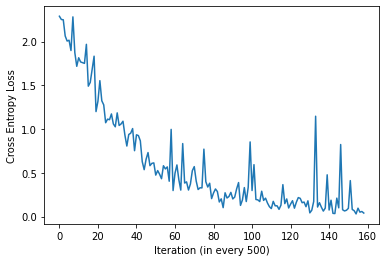

In [58]:
print (iteration_loss)
plt.plot(iteration_loss)
plt.ylabel('Cross Entropy Loss')
plt.xlabel('Iteration (in every 500)')
plt.savefig('plot_9.png', dpi=600, bbox_inches='tight')
plt.show()

# Saving the Model

In [59]:
root_path = './Saved Models'
save_model = True

if save_model is True:
    # Saves only parameters
    # weights & biases
    torch.save(model.state_dict(), root_path + '170104021_9.pkl') 